## Import Libraries

In [1]:
## Importing libraries
import pandas as pd
import numpy as np
import cv2
import os
import glob
from PIL import Image
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

## Loading Data

In [7]:
DIRECTORY = '../Data/'
CATEGORIES = ['Cloth mask','Mask worn incorrectly','N-95_Mask','No Face Mask','Surgical Mask']

data = []
labels = []
 
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    average1 = 0  
    average2 = 0
    number =  0
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        
        try:
            image = Image.open(img_path)
            average1 +=image.size[0]
            average2 +=image.size[1]
            number +=1
            data.append(image)
            labels.append(category)
            #image = train_transforms(image)
        except:
            pass  
    average1 = average1 /number 
    average2 = average2 /number 
    print("Average for class ",category," is ", average1, "X", average2)

Average for class  Cloth mask  is  461.1581508515815 X 422.3211678832117
Average for class  Mask worn incorrectly  is  395.42 X 424.575
Average for class  N-95_Mask  is  327.709219858156 X 289.82978723404256
Average for class  No Face Mask  is  239.9175704989154 X 227.0108459869848
Average for class  Surgical Mask  is  407.1542288557214 X 350.7910447761194


In [8]:
total_images = len(data)
train_dataset_size = 1580
test_dataset_size = total_images - train_dataset_size
test_dataset_percentage = test_dataset_size/total_images
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=test_dataset_percentage, random_state=42)
data_train, data_val, labels_train, labels_val = train_test_split(data_train, labels_train, test_size=0.1, random_state=42)

In [4]:
# Imagenet standards
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Train uses data augmentation
train_transforms = transforms.Compose([
        transforms.Resize((224,224)),
#        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(10),
#        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
#        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))  
])
    
# Validation does not use augmentation
test_transforms = transforms.Compose([
        transforms.Resize((224,224)),
#        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    ])

In [5]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
labels_train = lb_make.fit_transform(labels_train)
labels_val = lb_make.transform(labels_val)
labels_test = lb_make.transform(labels_test)

In [6]:
train_images = []
train_labels = []


for i in range(len(data_train)):
    try:
        train_images.append(train_transforms(data_train[i]))
        train_labels.append(labels_train[i])
    except:
        pass
    
val_images = []
val_labels = []
for i in range(len(data_test)):
    try:
        val_images.append(test_transforms(data_val[i]))
        val_labels.append(labels_val[i])
    except:
        pass

test_images = []
test_labels = []
for i in range(len(data_test)):
    try:
        test_images.append(test_transforms(data_test[i]))
        test_labels.append(labels_test[i])
    except:
        pass

In [7]:
train_images_numpy = [t.numpy() for t in train_images]
val_images_numpy = [t.numpy() for t in val_images]
test_images_numpy = [t.numpy() for t in test_images]

train_labels_tensor = torch.tensor(train_labels)
val_labels_tensor = torch.tensor(val_labels)
test_labels_tensor = torch.tensor(test_labels)

train_images_tensor = torch.tensor(train_images_numpy)
val_images_tensor = torch.tensor(val_images_numpy)
test_images_tensor = torch.tensor(test_images_numpy)

C:\Users\Maryam\AppData\Local\Temp/ipykernel_9472/3818321563.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  train_images_tensor = torch.tensor(train_images_numpy)


In [8]:
val_labels_tensor = val_labels_tensor.to(torch.long)

In [9]:
class CreateDataset:
    def __init__(self, images, labels):
        
        self.images = images
        self.labels = labels
    
    def __getitem__(self, index):
        
        image = self.images[index]
        label = self.labels[index]
        
        return image, label
    
    def __len__(self):
        return len(self.labels)

In [10]:
train_dataset = CreateDataset(images=train_images_tensor, labels=train_labels_tensor)
val_dataset = CreateDataset(images=val_images_tensor, labels=val_labels_tensor)
test_dataset = CreateDataset(images=test_images_tensor, labels=test_labels_tensor)

In [11]:
train_labels_tensor

tensor([0, 1, 3,  ..., 2, 4, 2])

In [12]:
batch_size_train = 64
batch_size_val = 64
batch_size_test = 64

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size_train,
                                           shuffle=True,
                                           drop_last=False)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=batch_size_val,
                                           shuffle=True,
                                           drop_last=False)                                           

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                         batch_size=batch_size_test,
                                         shuffle=False,
                                         drop_last=False)

In [13]:
def show_transformed_images(dataset, batch_size):
    #loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    batch = next(iter(dataset))
    images, labels = batch
    
    grid = trochvision.utils.make_grid(images, nrow = 3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ', labels)

In [14]:
# from torchvision.utils import make_grid
# import matplotlib.pyplot as plt

# def show_batch(dl):
#     """Plot images grid of single batch"""
#     for images, labels in dl:
#         fig,ax = plt.subplots(figsize = (16,12))
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
#         break
        
# show_batch(train_loader)

## Building Network

In [15]:
class net_ver1(nn.Module):
    def __init__(self):
        super(net_ver1, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
        )
        
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(28 * 28 * 128, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 5)
        )

        # self.final_layer = nn.Softmax(dim=1)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        # x = self.final_layer(x)
        # torch.argmax(x.reshape(-1))
        return F.log_softmax(x, dim = 1)

In [ ]:
model.to(device)

In [16]:
learning_rate = 0.001
model = net_ver1()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [17]:
num_epochs = 100
total_step = len(train_loader)

loss_list_train = []
loss_list_val = []
loss_train_avg = []
loss_val_avg = []

acc_list_train = []
acc_list_val = []
acc_train_avg = []
acc_val_avg = []

for epoch in range(num_epochs):
    
    model.train()
    loss_list_train = []
    acc_list_train = []
    
    for i, (images,labels) in enumerate(train_loader):
        
        
        images = images.reshape(-1,3,224,224)
        #print(images.shape, labels.shape)
        # Forward pass
        outputs = model(images)
        #print(labels)
        #print('outputs: ',outputs, outputs.shape)
        #print(labels.shape)
        #print(image)
        loss = criterion(outputs, labels)
        loss_list_train.append(loss.item())
        
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Train accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list_train.append(correct / total)
        
        # if (i + 1) % 100 == 0:
        # print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
        # .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
        # (correct / total) * 100))



    loss_train_avg.append(sum(loss_list_train)/len(train_loader))
    acc_train_avg.append(sum(acc_list_train)/len(train_loader))
    
    # print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
    # .format(epoch + 1, num_epochs, loss_train_avg[epoch],
    #  acc_train_avg[epoch] * 100))

    loss_list_val = []
    acc_list_val = []
    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images,labels) in enumerate(val_loader):
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_list_val.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            acc_list_val.append(correct / total)
            # print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
            #     .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
            #     (correct / total) * 100))

        loss_val_avg.append(sum(loss_list_val)/len(val_loader))
        acc_val_avg.append(sum(acc_list_val)/len(val_loader))

        # print('Validation Accuracy of the model on the validation images: {} %'
        # .format((correct / total) * 100))

    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}, Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'
    .format(epoch + 1, num_epochs, loss_train_avg[epoch], acc_train_avg[epoch] * 100,
    loss_val_avg[epoch], acc_val_avg[epoch] * 100))

Epoch [1/100], Train Loss: 1.5690, Train Accuracy: 28.91, Validation Loss: 1.5691, Validation Accuracy: 37.08%
Epoch [2/100], Train Loss: 1.4175, Train Accuracy: 43.26, Validation Loss: 1.4139, Validation Accuracy: 45.90%
Epoch [3/100], Train Loss: 1.3013, Train Accuracy: 49.00, Validation Loss: 1.2983, Validation Accuracy: 56.03%
Epoch [4/100], Train Loss: 1.1879, Train Accuracy: 57.58, Validation Loss: 1.2032, Validation Accuracy: 57.00%
Epoch [5/100], Train Loss: 1.1136, Train Accuracy: 59.35, Validation Loss: 1.1316, Validation Accuracy: 57.37%
Epoch [6/100], Train Loss: 1.0441, Train Accuracy: 62.10, Validation Loss: 1.0681, Validation Accuracy: 62.47%
Epoch [7/100], Train Loss: 0.9954, Train Accuracy: 66.11, Validation Loss: 1.1068, Validation Accuracy: 62.92%
Epoch [8/100], Train Loss: 0.9193, Train Accuracy: 69.10, Validation Loss: 1.0629, Validation Accuracy: 63.29%
Epoch [9/100], Train Loss: 0.8588, Train Accuracy: 71.52, Validation Loss: 1.0135, Validation Accuracy: 67.83%
E

KeyboardInterrupt: 

In [18]:
# Test:
output_true = []
output_pred = []

with torch.no_grad():
    correct = 0
    total = 0
    for i, (images,labels) in enumerate(test_loader):
        output_true.append(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        output_pred.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Testing Accuracy of the model on the test images: {} %'
        .format((correct / total) * 100))

Testing Accuracy of the model on the test images: 67.62886597938144 %


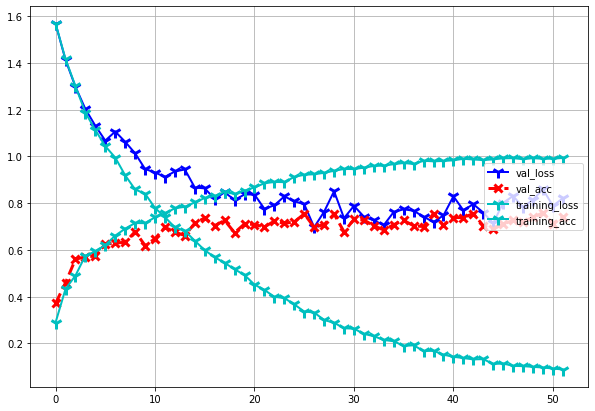

In [20]:
plt.figure(figsize=(10,7))
plt.plot(loss_val_avg, 'b-1', markersize=12, markeredgewidth=3
         , linewidth=2,label='val_loss')
plt.plot(acc_val_avg, 'r--x', markersize=8, markeredgewidth=3
         , linewidth=3,label='val_acc')
plt.plot(loss_train_avg, 'c-1', markersize=12, markeredgewidth=3
         , linewidth=2,label='training_loss')
plt.plot(acc_train_avg, 'c-1', markersize=12, markeredgewidth=3
         , linewidth=2,label='training_acc')
plt.grid()
plt.legend(loc='center right')

In [64]:
y_pred = np.zeros(len(output_pred)*output_pred[0].shape[0])
y_true = np.zeros(len(output_true)*output_true[0].shape[0])
for i in range(len(output_pred)):
    y_pred[i*output_pred[0].shape[0]:(i+1)*output_pred[0].shape[0]] = output_pred[i]
    y_true[i*output_true[0].shape[0]:(i+1)*output_true[0].shape[0]] = output_true[i]
    

y_pred = y_pred.reshape(-1)
y_true = y_true.reshape(-1)

ValueError: could not broadcast input array from shape (37,) into shape (64,)

In [65]:
len(output_pred)

8

In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.69      0.80      0.74       139
         1.0       0.42      0.47      0.44        96
         2.0       0.57      0.69      0.62        89
         3.0       0.85      0.62      0.72       112
         4.0       0.64      0.46      0.53        76

    accuracy                           0.63       512
   macro avg       0.63      0.61      0.61       512
weighted avg       0.65      0.63      0.63       512



In [40]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true, y_pred)
print('confusiton matrix: ', conf_mat)

array([[111,  16,   6,   3,   3],
       [ 21,  45,  14,   4,  12],
       [  2,  18,  61,   3,   5],
       [ 20,  17,   6,  69,   0],
       [  7,  12,  20,   2,  35]], dtype=int64)

In [ ]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T


plt.rcParams["savefig.bbox"] = 'tight'
orig_img = Image.open(Path('assets') / 'astronaut.jpg')
# if you change the seed, make sure that the randomly-applied transforms
# properly show that the image can be both transformed and *not* transformed!
torch.manual_seed(0)


def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [29]:
class net_ver2(nn.Module):
    def __init__(self):
        super(net_ver2, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
        )
        
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(56 * 56 * 64, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 5)
        )

        # self.final_layer = nn.Softmax(dim=1)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        #x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        # x = self.final_layer(x)
        # torch.argmax(x.reshape(-1))
        return F.log_softmax(x, dim = 1)

In [30]:
learning_rate = 0.001
model = net_ver2()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'outputs/final_model.pth')